In [1]:
import torch
from diff3f import get_features_per_vertex
%load_ext autoreload
%autoreload 2
from diff3f_w_tex import compute_features_from_mesh, Mesh_from_obj
from time import time
from utils import convert_mesh_container_to_torch_mesh, cosine_similarity, double_plot, get_colors, generate_colors
from dataloaders.mesh_container import MeshContainer
from diffusion import init_pipe
from dino import init_dino
from functional_map import compute_surface_map
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesUV
import numpy as np
from PIL import Image

/opt/conda/envs/saus/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
device = torch.device('cuda:0')

In [3]:
pipe = init_pipe(device)
dino_model = init_dino(device)

/opt/conda/envs/saus/lib/python3.8/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is

In [4]:
torch.cuda.empty_cache()

# test

In [5]:
rp_obj_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/rp/rp_carla_rigged_001.obj"
rp_tex_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/rp/rp_carla_rigged_001_mask.jpg"
f_target = compute_features_from_mesh(device, pipe, dino_model, rp_obj_path, rp_tex_path, "a person posed",use_tex=True)

/opt/conda/envs/saus/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /source/sihun/SAUS_prev/Diffusion-3D-Features/rp/rp_carla_rigged_001.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


num mesh_vertices:  10067
35000
Rendering complete


/opt/conda/envs/saus/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905975447/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [08:50<00:00,  5.30s/it]

Number of missing features:  1178
Copied features from nearest vertices
Time taken in mins:  9.547118151187897


In [6]:
torch.save(f_target, 'diff3f_rp.pt')

In [7]:
smpl_obj_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/smpl/smpl_mesh_1.obj"
smpl_tex_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/smpl/SMPL_sampleTex_m.jpg"
f_source = compute_features_from_mesh(device, pipe, dino_model, smpl_obj_path, smpl_tex_path, "a person posed",use_tex=True)
torch.save(f_source, 'diff3f_smpl.pt')

/opt/conda/envs/saus/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /source/sihun/SAUS_prev/Diffusion-3D-Features/smpl/smpl_mesh_1.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


num mesh_vertices:  6890
35000
Rendering complete


100%|██████████| 100/100 [08:48<00:00,  5.29s/it]

Number of missing features:  41
Copied features from nearest vertices
Time taken in mins:  9.295297384262085


In [8]:
#f_target.shape
# torch.save(f_target, 'rp_diff3f.pt')
f_source=torch.load('smpl_diff3f.pt')
# f_source=torch.load('smpl_diff3f.pt')
# f_source.shape

In [42]:
source_mesh = MeshContainer().load_from_file(smpl_obj_path)
#target_mesh = MeshContainer().load_from_file(rp_obj_path)
mesh = Mesh_from_obj(rp_obj_path, rp_tex_path, device=device)
target_mesh = MeshContainer(mesh.verts_list()[0], mesh._faces_list[0])

In [43]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert)
cmap_target = cmap_source[s]
# s = cosine_similarity(f_target.to(device),f_source.to(device))
# s = torch.argmax(s, dim=0).cpu().numpy()
# cmap_target = get_colors(target_mesh.vert)
# cmap_source = cmap_target[s]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)

In [32]:
import meshplot as mp
cmap1,cmap2=cmap_source,cmap_target
# d = mp.subplot(source_mesh.vert, source_mesh.face, c=cmap1, s=[2, 2, 0])
mp.subplot(target_mesh.vert, target_mesh.face, c=cmap2, s=[2, 2, 1], data=d)

Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


In [34]:
target_mesh.face.shape

(19988, 3)

In [26]:
print(cmap_source.shape, cmap_target.shape)

(6890, 3) (11586, 3)


In [27]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert)
cmap_target = cmap_source[s]
print(cmap_source.shape, cmap_target.shape)

(6890, 3) (10067, 3)


In [17]:
cmap_target.max()

0.9982150862894396

In [16]:
cmap_source.max()

1.0

In [14]:
rp_obj_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/rp/rp_carla_rigged_001.obj"
rp_tex_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/rp/rp_carla_rigged_001_mask.jpg"
f_target = compute_features_from_mesh(device, pipe, dino_model, rp_obj_path, rp_tex_path, "a person posed",use_tex=False)

smpl_obj_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/smpl/smpl_mesh_1.obj"
smpl_tex_path = "/source/sihun/SAUS_prev/Diffusion-3D-Features/smpl/SMPL_sampleTex_m.jpg"
f_source = compute_features_from_mesh(device, pipe, dino_model, smpl_obj_path, smpl_tex_path, "a person posed",use_tex=False)

source_mesh = MeshContainer().load_from_file(smpl_obj_path)
target_mesh = MeshContainer().load_from_file(rp_obj_path)

# s = cosine_similarity(f_source.to(device),f_target.to(device))
# s = torch.argmax(s, dim=0).cpu().numpy()
# cmap_source = get_colors(source_mesh.vert)
# cmap_target = cmap_source[s]
s = cosine_similarity(f_target.to(device),f_source.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_target = get_colors(target_mesh.vert)
cmap_source = cmap_target[s]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)

In [15]:
mesh_vertices

tensor([[ 0.0478,  1.7285,  0.0937],
        [ 0.0426,  1.7161,  0.1040],
        [ 0.0534,  1.7107,  0.0953],
        ...,
        [-0.0761,  1.6600,  0.0063],
        [-0.0768,  1.6613,  0.0084],
        [-0.0793,  1.6595,  0.0112]], device='cuda:0')

In [21]:

t1 = time()
if mesh_vertices is None:
    mesh_vertices = mesh.verts_list()[0]
if len(mesh_vertices) > VERTEX_GPU_LIMIT:
    samples = random.sample(range(len(mesh_vertices)), 10000)
    maximal_distance = torch.cdist(mesh_vertices[samples], mesh_vertices[samples]).max()
else:
    maximal_distance = torch.cdist(mesh_vertices, mesh_vertices).max()  # .cpu()
ball_drop_radius = maximal_distance * tolerance
batched_renderings, normal_batched_renderings, camera, depth = batch_render(
    device, mesh, mesh.verts_list()[0], num_views, H, W, use_normal_map
)
print("Rendering complete")

Rendering complete


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 512, 512, 4])
tensor(0.)
tensor(1.1094)


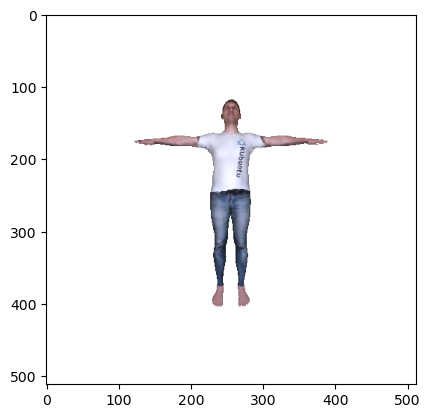

In [60]:
print(batched_renderings.shape)
print(batched_renderings.min())
print(batched_renderings.max())
plt.imshow(batched_renderings[0].detach().cpu().numpy())

In [29]:
if use_normal_map:
    normal_batched_renderings = normal_batched_renderings.cpu()
batched_renderings = batched_renderings.cpu()
pixel_coords = arange_pixels((H, W), invert_y_axis=True)[0]
pixel_coords[:, 0] = torch.flip(pixel_coords[:, 0], dims=[0])
grid = arange_pixels((H, W), invert_y_axis=False)[0].to(device).reshape(1, H, W, 2).half()
camera = camera.cpu()
normal_map_input = None
depth = depth.cpu()
torch.cuda.empty_cache()
ft_per_vertex = torch.zeros((len(mesh_vertices), FEATURE_DIMS)).half()  # .to(device)
ft_per_vertex_count = torch.zeros((len(mesh_vertices), 1)).half()  # .to(device)

In [30]:
idx = 0
dp = depth[idx].flatten().unsqueeze(1)
xy_depth = torch.cat((pixel_coords, dp), dim=1)
indices = xy_depth[:, 2] != -1
xy_depth = xy_depth[indices]
world_coords = (
    camera[idx].unproject_points(
        xy_depth, world_coordinates=True, from_ndc=True
    )  # .cpu()
).to(device)
diffusion_input_img = (
    batched_renderings[idx, :, :, :3].cpu().numpy() * 255
).astype(np.uint8)
if use_normal_map:
    normal_map_input = normal_batched_renderings[idx]
depth_map = depth[idx, :, :, 0].unsqueeze(0).to(device)
if prompts_list is not None:
    prompt = random.choice(prompts_list)
diffusion_output = add_texture_to_render(
    pipe,
    diffusion_input_img,
    depth_map,
    prompt,
    normal_map_input=normal_map_input,
    use_latent=use_latent,
    num_images_per_prompt=num_images_per_prompt,
    return_image=return_image
)

In [113]:
diffusion_input_img.shape

(512, 512, 3)

In [62]:
print(batched_renderings[idx, :, :, :3].shape)
print(batched_renderings[idx, :, :, :3].min())
print(batched_renderings[idx, :, :, :3].max())
pil_b_rnd = ToPILImage()(batched_renderings[idx, :, :, :3].permute(2,0,1))
aligned_dino_features = get_dino_features(device, dino_model, pil_b_rnd, grid)
aligned_dino_features.shape

torch.Size([512, 512, 3])
tensor(0.0227)
tensor(1.1094)


torch.Size([1, 768, 262144])

2
torch.Size([1280, 32, 32])
(32, 32, 1)
tensor(0.7681, device='cuda:0', dtype=torch.float16)
tensor(0.7793, device='cuda:0', dtype=torch.float16)
1
(512, 512)


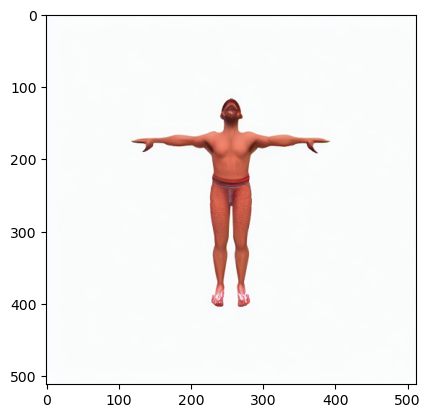

In [32]:
print(len(diffusion_output))
print(diffusion_output[0].shape)
print(diffusion_output[0][0][None].cpu().numpy().transpose(1,2,0).shape)
print(diffusion_output[0][0].max())
print(diffusion_output[0][1].max())
# plt.imshow(diffusion_output[0][0][None].cpu().numpy().transpose(1,2,0))

print(len(diffusion_output[1]))
print(diffusion_output[1][0].shape)
plt.imshow(diffusion_output[1][0])

In [ ]:

for idx in tqdm(range(len(batched_renderings))):
    dp = depth[idx].flatten().unsqueeze(1)
    xy_depth = torch.cat((pixel_coords, dp), dim=1)
    indices = xy_depth[:, 2] != -1
    xy_depth = xy_depth[indices]
    world_coords = (
        camera[idx].unproject_points(
            xy_depth, world_coordinates=True, from_ndc=True
        )  # .cpu()
    ).to(device)
    diffusion_input_img = (
        batched_renderings[idx, :, :, :3].cpu().numpy() * 255
    ).astype(np.uint8)
    if use_normal_map:
        normal_map_input = normal_batched_renderings[idx]
    depth_map = depth[idx, :, :, 0].unsqueeze(0).to(device)
    if prompts_list is not None:
        prompt = random.choice(prompts_list)
    diffusion_output = add_texture_to_render(
        pipe,
        diffusion_input_img,
        depth_map,
        prompt,
        normal_map_input=normal_map_input,
        use_latent=use_latent,
        num_images_per_prompt=num_images_per_prompt,
        return_image=return_image
    )
    aligned_dino_features = get_dino_features(device, dino_model, diffusion_output[1][0], grid)
    aligned_features = None
    with torch.no_grad():
        ft = torch.nn.Upsample(size=(H,W), mode="bilinear")(diffusion_output[0].unsqueeze(0)).to(device)
        ft_dim = ft.size(1)
        aligned_features = torch.nn.functional.grid_sample(
            ft, grid, align_corners=False
        ).reshape(1, ft_dim, -1)
        aligned_features = torch.nn.functional.normalize(aligned_features, dim=1)
    # this is feature per pixel in the grid
    aligned_features = torch.hstack([aligned_features*0.5, aligned_dino_features*0.5])
    features_per_pixel = aligned_features[0, :, indices].cpu()
    # map pixel to vertex on mesh
    if bq:
        queried_indices = (
            ball_query(
                world_coords.unsqueeze(0),
                mesh_vertices.unsqueeze(0),
                K=100,
                radius=ball_drop_radius,
                return_nn=False,
            )
            .idx[0]
            .cpu()
        )
        mask = queried_indices != -1
        repeat = mask.sum(dim=1)
        ft_per_vertex_count[queried_indices[mask]] += 1
        ft_per_vertex[queried_indices[mask]] += features_per_pixel.repeat_interleave(
            repeat, dim=1
        ).T
    else:
        distances = torch.cdist(
        world_coords, mesh_vertices, p=2
        )
        closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
        ft_per_vertex[closest_vertex_indices] += features_per_pixel.T
        ft_per_vertex_count[closest_vertex_indices] += 1

idxs = (ft_per_vertex_count != 0)[:, 0]
ft_per_vertex[idxs, :] = ft_per_vertex[idxs, :] / ft_per_vertex_count[idxs, :]
missing_features = len(ft_per_vertex_count[ft_per_vertex_count == 0])
print("Number of missing features: ", missing_features)
print("Copied features from nearest vertices")

if missing_features > 0:
    filled_indices = ft_per_vertex_count[:, 0] != 0
    missing_indices = ft_per_vertex_count[:, 0] == 0
    distances = torch.cdist(
        mesh_vertices[missing_indices], mesh_vertices[filled_indices], p=2
    )
    closest_vertex_indices = torch.argmin(distances, dim=1).cpu()
    ft_per_vertex[missing_indices, :] = ft_per_vertex[filled_indices][
        closest_vertex_indices, :
    ]
t2 = time() - t1
t2 = t2 / 60
print("Time taken in mins: ", t2)
return ft_per_vertex
